<a href="https://colab.research.google.com/github/hoangtruong296/CodePtit-OOPJava-/blob/main/translatation_transformer_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Link bài báo
> https://arxiv.org/pdf/1706.03762



In [ ]:
# Download and execute set up script
# !wget -O py39.sh https://raw.githubusercontent.com/j3soon/colab-python-version/main/scripts/py39.sh
# !bash py39.sh

In [ ]:
# !pip install torch==1.9.0 torchtext==0.10.0 nltk numpy=1.23.0 pandas matplotlib
# import nltk
# nltk.download('wordnet')
# !pip install setuptools
# !pip install spacy==3.7.5
# !python -m spacy download en_core_web_sm

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.autograd import Variable
import numpy as np
import math, copy
import matplotlib.pyplot as plt

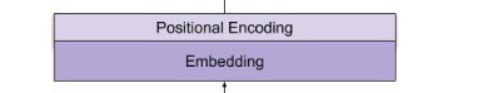

In [ ]:
# Embedding layer
class Embedder(nn.Module):

  """
      Khởi tạo lớp Embedder để chuyển đổi tokens thành vector nhúng.
      Args:
          vocab_size (int): số lượng token khác nhau trong bộ từ vựng
          d_model (int): số chiều của vector nhúng
  """
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.vocab_size = vocab_size
    self.d_model = d_model
    # Tạo một Embedding layer là một ma trận có kích thước vocab_size x d_model
    self.embed = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    # x là dữ liệu đầu vào
    # Đầu ra là các vector nhúng tương ứng với mỗi token
    return self.embed(x)

In [ ]:
# Test Embedder
vocab_size = 100 # 100 từ
d_model = 16 # vector nhúng có 16 chiều
sequence_length = 10 # độ dài câu là 10
batch_size = 2

embedder = Embedder(vocab_size, d_model)
# Tạo input giả định
x = torch.randint(0, vocab_size, (batch_size, sequence_length))
print(x)
output = embedder(x)
print(output.shape)
print(output[0,])

tensor([[35, 95, 87, 39, 70, 32, 49, 47,  8, 69],
        [20, 31, 63, 52, 93,  5, 40, 30, 78, 95]])
torch.Size([2, 10, 16])
tensor([[ 1.9529, -0.7256, -2.5962,  0.6581,  0.3634, -0.0309, -0.3544, -1.1133,
          1.6291,  0.5583,  0.9489, -1.1311, -0.1328,  0.1572,  0.9183,  1.0884],
        [ 2.3853, -0.4909,  1.0325,  0.4885,  0.8038,  1.1565, -0.4993,  0.4004,
         -1.0240, -0.7126,  2.1136, -1.6724, -0.6461, -1.3504, -0.0462,  0.0190],
        [-0.5336, -0.7757,  0.2866,  0.2409,  1.2040,  1.7348,  0.2278,  0.8084,
          1.4314, -1.5547,  0.4644,  0.8618,  0.7362,  1.3775, -0.6712, -0.6220],
        [ 0.7475,  1.6742,  1.6998,  0.5872, -0.0276, -1.5861,  0.7597, -0.3247,
          0.0405, -1.9925, -0.7160, -0.0127, -0.1690, -0.8649, -0.6426,  0.7997],
        [-1.9123, -1.5248,  0.9229, -0.5751, -1.4080,  0.3716, -0.4451,  0.9998,
         -0.2379, -0.8753, -0.8962,  0.0917,  1.3353, -1.5618,  1.1991,  1.7350],
        [ 1.0700, -0.5887,  0.8969, -0.5090, -0.7263,  2.062

In [ ]:
# Positional Encoding
class PositionalEnconder(nn.Module):
  """
      Lớp Positional Enconding giúp mã hóa vị trí các token
              PE(pos,2i) = sin(pos/10000^(2i/d_model))
              PE(pos,2i+1) = cos(pos/10000^(2i/d_model))
      Args:
          d_model (int): số chiều của vector nhúng
          max_seq_len (int): độ dài tối đa của câu
          dropout (float): tỉ lệ dropout neurons để tránh overfitting
  """
  def __init__(self, d_model, max_seq_len=200, dropout=0.1):
    super().__init__()
    self.d_model = d_model
    self.dropout = nn.Dropout(dropout)
    # Khởi tạo ma trận của PE
    pe = torch.zeros(max_seq_len, d_model)
    # Tính ma trận
    position = torch.arange(0., max_seq_len).unsqueeze(1)  # (max_seq_len, 1)
    div_term = torch.exp(torch.arange(0., d_model, 2) * -(math.log(10000.0) / d_model)) # (d_model//2,)
    pe[:, 0::2] = torch.sin(position * div_term) # broadcasting: (max_seq_len, d_model)
    pe[:, 1::2] = torch.cos(position * div_term)
    # Thêm chiều của batch để tương thích với dữ liệu đầu vào mô hình
    pe = pe.unsqueeze(0)
    # Do PE chỉ sử dụng công thức cố định , không cần cập nhật trong quá trình training
    # lưu vào mô hình sử dụng cho khối sau
    self.register_buffer('pe', pe)
  def forward(self, x):
    # Trả về embedding vector đã xử lí
    # x là tensor chứa các embedding vector của các token từ Embedding Layer
    # Trong bài báo tác giả có nói lấy embedding vector nhân với căn 2 của d_model
    # Điều này giúp cho ý nghĩa của embedding vector sẽ không bị mất khi cộng cả 2 với nhau
    x = x * math.sqrt(self.d_model)

    pe = Variable(self.pe[:, :x.size(1)], requires_grad=False)
    if x.is_cuda:
      pe.cuda()
    x = x + pe
    return self.dropout(x)



In [ ]:
pos_encoder = PositionalEnconder(d_model)
enc_output = pos_encoder(output)
print(enc_output.shape)
print(enc_output[0,])

torch.Size([2, 10, 16])
tensor([[  8.6794,  -2.1139, -11.5386,   4.0360,   0.0000,   0.9739,  -1.5752,
          -3.8370,   7.2405,   3.5923,   4.2171,  -3.9160,  -0.5901,   1.8096,
           4.0811,   5.9486],
        [ 11.5364,  -1.5813,   4.9343,   3.2271,   3.6833,   6.2454,  -2.1839,
           2.8901,  -4.5401,  -2.0563,   9.3975,  -6.3219,  -2.8703,  -4.8906,
          -0.2051,   1.1957],
        [ -1.3611,  -3.9099,   0.0000,   1.9670,   0.0000,   8.7992,   1.0826,
           4.7019,   6.3839,  -5.7989,   2.0712,   0.0000,   0.0000,   7.2333,
          -2.9823,  -1.6533],
        [  0.0000,   6.3408,   8.4576,   3.2575,   0.2058,  -5.9881,   0.0000,
          -0.3370,   0.2132,  -7.7451,  -3.1716,   1.0546,  -0.7480,  -2.7330,
          -2.8551,   0.0000],
        [ -9.3398,  -7.5030,   5.1613,  -2.2213,  -0.0000,   2.6751,  -0.0000,
           5.5458,  -1.0127,  -2.7801,  -3.9693,   1.5184,   5.9390,  -5.8302,
           5.3310,   8.8220],
        [  3.6901,  -2.3014,   5.097

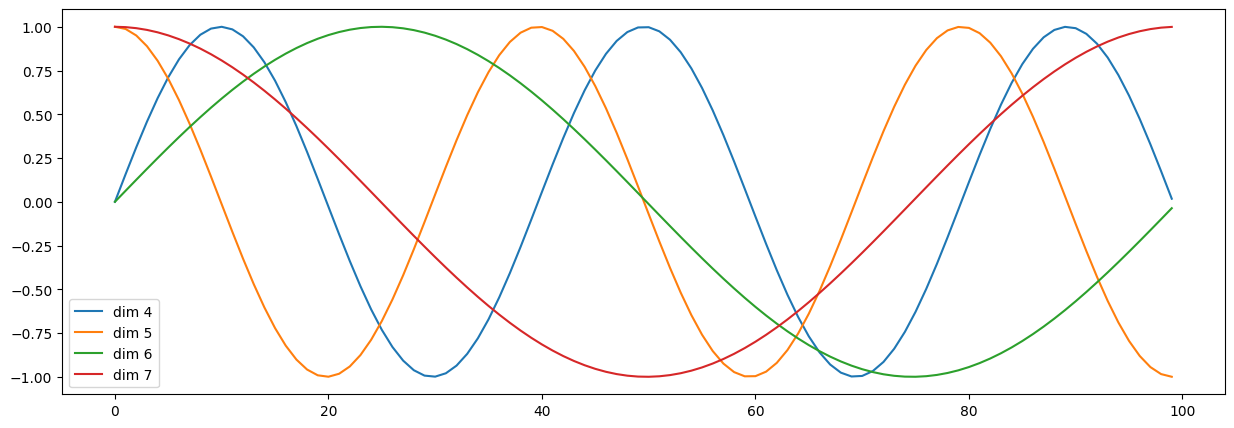

In [ ]:
plt.figure(figsize=(15, 5))
pe = PositionalEnconder(20, dropout=0)
y = pe(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d" % p for p in [4, 5, 6, 7]])

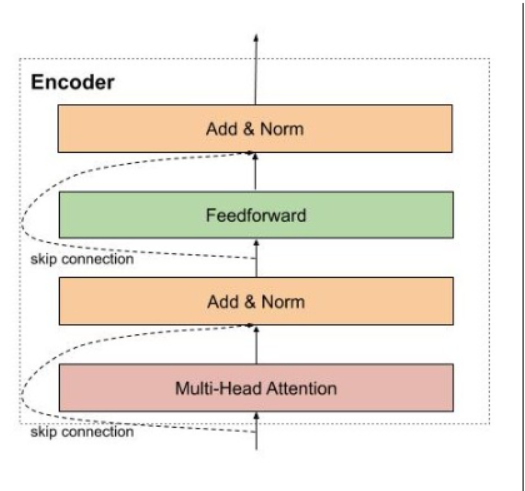

In [ ]:
# Encode layer

def attention(q, k, v, mask=None, dropout=None):
    """
    Co che self-attention
    Args:
        q: batch_size x head x seq_length x d_model
        k: batch_size x head x seq_length x d_model
        v: batch_size x head x seq_length x d_model
        mask: batch_size x 1 x 1 x seq_length
        output: batch_size x head x seq_length x d_model
    """
    # Scaled Dot-Product Attention
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(q.size(-1)) # batch_size x head x seq_length x seq_length

    # Mask cho các vị trí không được chú ý đến hay có điểm attention thấp
    if mask is not None:
      mask = mask.unsqueeze(-1)
      scores = scores.masked_fill(mask == 0, -1e9)
    # Chuan hoa softmax
    scores = func.softmax(scores, dim=-1)

    if dropout is not None:
      scores = dropout(scores)

    output = torch.matmul(scores, v)
    return output, scores


In [ ]:
size = torch.rand(32, 8, 30, 512)

out, score = attention(size, size, size)

print(out.shape)
score.shape

torch.Size([32, 8, 30, 512])


torch.Size([32, 8, 30, 30])

In [ ]:
# Test nn.Linear
# Ap dung cho tung vector rieng biet (token) trong sequence trong batch
data = torch.tensor([23., 12., 33., 4.01, -65.]) # nn.Linear only support float32
print("Data before Transformation:\n", data)
print("dtype of Data:", data.dtype)
print("Size of Data:", data.size())

Data before Transformation:
 tensor([ 23.0000,  12.0000,  33.0000,   4.0100, -65.0000])
dtype of Data: torch.float32
Size of Data: torch.Size([5])


In [ ]:
in_features = 5
out_features = 3

linear = nn.Linear(in_features, out_features)
data_out = linear(data)
print("Data after Transformation:\n", data_out)
print("Size of Data after Transformation:", data_out.size())

Data after Transformation:
 tensor([-33.4289,   6.9276,  20.0893], grad_fn=<AddBackward0>)
Size of Data after Transformation: torch.Size([3])


In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, heads, d_model, dropout=0.1):
    super().__init__()
    assert d_model % heads == 0 # Dam bao moi head se xu li so chieu bang nhau
    self.d_model = d_model
    self.heads = heads
    self.d_k = d_model // heads
    self.attn = None
    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)

    self.dropout = nn.Dropout(dropout)
    self.out = nn.Linear(d_model, d_model)
  def forward(self, q, k, v, mask=None):
    """
    Args:
        q: batch_size x seq_length x d_model
        k: batch_size x seq_length x d_model
        v: batch_size x seq_length x d_model
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
    """
    batches = q.size(0)
    # Do cả khi mới chỉ có input x thì cả q, k và v sẽ bằng nhau. Chúng chỉ khác nhau khi nhân với ma trận trọng số
    q = self.w_q(q).view(batches, -1, self.heads, self.d_k).transpose(1, 2)
    k = self.w_k(k).view(batches, -1, self.heads, self.d_k).transpose(1, 2)
    v = self.w_v(v).view(batches, -1, self.heads, self.d_k).transpose(1, 2)

    scores, self.attn = attention(q, k, v, mask)

    concat = scores.transpose(1, 2).contiguous().view(batches, -1, self.heads * self.d_k)

    output = self.out(concat) # batches x seq_length x d_model

    return output


In [ ]:
out= MultiHeadAttention(8, 512)(torch.rand(32, 30, 512), torch.rand(32, 30, 512), torch.rand(32, 30, 512))

out.shape

torch.Size([32, 30, 512])

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self, d_model, eps=1e-6):
    super().__init__()
    self.size = d_model
    # Create scaling and shifting parameter
    self.gamma = nn.Parameter(torch.ones(self.size))
    self.bias = nn.Parameter(torch.zeros(self.size))

    self.eps = eps
  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = ((x - mean) ** 2).mean(dim=-1, keepdim=True)
    std = (var + self.eps).sqrt()
    y = (x - mean)/std
    layernorm = self.gamma * y + self.bias
    return layernorm

In [ ]:
class SublayerConnection(nn.Module):
  def __init__(self, d_model, dropout):
    super().__init__()

    self.norm = LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout)
  # Moi sub-layer dc boc trong 1 residual connection cung voi normalization layer
  # Output = LayerNorm(x + Sublayer(x))
  def forward(self, x, sublayer):
    return x + self.dropout(sublayer(self.norm(x))) #PreLN

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, d_model, d_ff=2048, dropout=0.1):
    super().__init__()

    self.w_1 = nn.Linear(d_model, d_ff)
    self.w_2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    return self.w_2(self.dropout(func.relu(self.w_1(x))))

In [ ]:
def clones(module, N):
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class EncoderLayer(nn.Module):
  def __init__(self, d_model, heads, dropout=0.1):
    super().__init__()
    self.attn = MultiHeadAttention(heads, d_model)
    self.ffn = FeedForward(d_model)
    self.sublayer = clones(SublayerConnection(d_model, dropout), 2)

  def forward(self, x, mask):
    """
      Args:
        x: batch_size x seq_length x d_model
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
    """
    x = self.sublayer[0](x, lambda x : self.attn(x, x, x, mask))
    return self.sublayer[1](x, self.ffn)


In [ ]:
EncoderLayer(512, 8)(torch.rand(32, 30, 512), torch.rand(32, 1, 30)).shape

torch.Size([32, 30, 512])

In [ ]:
# Decoder
class DecoderLayer(nn.Module):
  def __init__(self, d_model, heads, dropout=0.1):
    super().__init__()
    self.attn1 = MultiHeadAttention(heads, d_model)
    self.attn2 = MultiHeadAttention(heads, d_model)
    self.ffn = FeedForward(d_model)
    self.sublayer = clones(SublayerConnection(d_model, dropout), 3)
  def forward(self, x, mem, src_mask, tgt_mask):
    """
      Args:
        x: batch_size x seq_length x d_model
        mem: batch_size x seq_length x d_model (output từ encoder)
        src_mask: batch_size x 1 x seq_length (mask cho input seq bỏ quả padding)
        tgt_mask: batch_size x 1 x seq_length (mask để ngăn nhìn vào tokens tương lai)
    """
    x = self.sublayer[0](x, lambda x: self.attn1(x, x, x, tgt_mask))
    x = self.sublayer[1](x, lambda x: self.attn2(x, mem, mem, src_mask))
    return self.sublayer[2](x, self.ffn)

In [ ]:
DecoderLayer(512, 8)(torch.rand(32, 30, 512), torch.rand(32, 30, 512), torch.rand(32, 1, 30), torch.rand(32, 1, 30)).shape

torch.Size([32, 30, 512])

# Transformer hoàn chỉnh

In [ ]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, d_model, N, heads, dropout):
    super().__init__()
    self.N = N
    self.embed = Embedder(vocab_size, d_model)
    self.pe = PositionalEnconder(d_model, dropout)
    self.layers = clones(EncoderLayer(d_model, heads, dropout), N)
    # Theo bai goc tac gia co viet la dung them 1 LayerNorm la tang cuoi cung cua encoder va decoder
    self.norm = LayerNorm(d_model)
  def forward(self, x, mask):
    """
    src: batch_size x seq_length
    mask: batch_size x 1 x seq_length
    output: batch_size x seq_length x d_model
    """
    x = self.embed(x)
    x = self.pe(x)
    for i in range(self.N):
      x = self.layers[i](x, mask)
    return self.norm(x)

In [ ]:
class Decoder(nn.Module):
  def __init__(self, vocab_size, d_model, N, heads, dropout):
    super().__init__()
    self.N = N
    self.embed = Embedder(vocab_size, d_model)
    self.pe = PositionalEnconder(d_model, dropout)
    self.layers = clones(DecoderLayer(d_model, heads, dropout), N)
    self.norm = LayerNorm(d_model)
  def forward(self, x, mem, src_mask, tgt_mask):
    x = self.embed(x)
    x = self.pe(x)
    for i in range(self.N):
      x = self.layers[i](x, mem, src_mask, tgt_mask)
    return self.norm(x)

In [ ]:
class Transformer(nn.Module):
  def __init__(self, src_vocab, tgt_vocab, d_model, N, heads, dropout):
    """
      src_vocab: tập từ tiếng Anh
      tgt_vocab: tập từ tiếng Việt
    """
    self.encoder = Encoder(src_vocab, d_model, N, heads, dropout)
    self.decoder = Decoder(src_vocab, d_model, N, heads, dropout)
    self.out = nn.Linear(d_model, tgt_vocab)
  def forward(self, src, tgt, src_mask, tgt_mask):
    """
      src: batch_size x seq_length
      tgt: batch_size x seq_length
      src_mask: batch_size x 1 x seq_length
      tgt_mask: batch_size x 1 x seq_length
      ouput: batch_size x seq_length X vocab_size
    """
    e_mem = self.encoder(src, src_mask)
    d_mem = self.decoder(tgt, e_mem, src_mask, tgt_mask)
    output = self.out(d_mem)

    return output

In [ ]:
!pip show torch torchtext

Name: torch
Version: 1.9.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.9/site-packages
Requires: typing-extensions
Required-by: torchtext
---
Name: torchtext
Version: 0.10.0
Summary: Text utilities and datasets for PyTorch
Home-page: https://github.com/pytorch/text
Author: PyTorch core devs and James Bradbury
Author-email: jekbradbury@gmail.com
License: BSD
Location: /usr/local/lib/python3.9/site-packages
Requires: numpy, requests, torch, tqdm
Required-by: 


In [ ]:
try:
    import torchtext
    print("Import thành công!")
except Exception as e:
    print(f"Lỗi khi import: {e}")

Import thành công!


In [ ]:
from torchtext.legacy import data
class MyIterator(data.Iterator):
  def create_batches(self):
    if self.train:
        def pool(d, random_shuffler):
          for p in data.batch(d, self.batch_size * 100):
            p_batch = data.batch(
                sorted(p, key=self.sort_key),
                self.batch_size, self.batch_size_fn
            )
            for b in random_shuffler(list(p_batch)):
              yield b
        self.batches = pool(self.data(), self.random_shuffler)
    else:
        self.batches = []
        for b in data.batch(self.data(), self.batch_size, self.batch_size_fn):
            self.batches.append(sorted(b, key=self.sort_key))

def batch_size_fn(new, count, sofar):
    global max_src_in_batch, max_tgt_in_batch
    if count == 1: # Neu la cau dau tien thi reset do dai
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src)) #Lay cau co do dai dai nhat cua tu dien src
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2) #Lay cau co do dai dai nhat cua tu dien tgt va + 2 vi co <sos> va <eos>
    src_elements = count * max_src_in_batch # Tinh tong so token trong 1 cau tinh ca padding
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements) # Tra ve do dai lon nhat

In [ ]:
def subsequent_mask(size, device):
  """
      Tạo mask cho Decoder
  """
  attn_shape = (1, size, size)
  subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
  subsequent_mask = Variable(torch.from_numpy(subsequent_mask) == 0)
  subsequent_mask = subsequent_mask.to(device)

  return subsequent_mask

def create_masks(src, trg, src_pad, tgt_pad, device):
    """
        Tạo mask cho Encoder
    """
    src_mask = (src != src_pad).unsqueeze(-2)

    if trg is not None:
        trg_mask = (trg != tgt_pad).unsqueeze(-2)
        size = trg.size(1) # get seq_len for matrix
        np_mask = subsequent_mask(size, device)
        if trg.is_cuda:
            np_mask.cuda()
        trg_mask = trg_mask & np_mask

    else:
        trg_mask = None
    return src_mask, trg_mask

# Preprocessing

In [ ]:
from nltk.corpus import wordnet
import re
# Tim tu dong nghia voi tu word trong tu dien SRC
def get_synonym(word, SRC):
    syns = wordnet.synsets(word) #Lay bo cac tu dong nghia
    for s in syns:
        for l in s.lemmas():
            if SRC.vocab.stoi[l.name()] != 0:
                return SRC.vocab.stoi[l.name()]
    return 0
# Thay thế nhiều chuỗi con trong một đoạn văn bản cùng lúc
def multiple_replace(dict, text):
  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text)

In [ ]:
def init_vars(src, model, SRC, TRG, device, k, max_len):
    """
        Tính toán các ma trận cần thiết trong quá trình translation sau khi mô hình học xong
    """
    init_tok = TRG.vocab.stoi['<sos>']
    src_mask = (src != SRC.vocab.stoi['<pad>']).unsqueeze(-2)

    # tính sẵn output của encoder
    e_output = model.encoder(src, src_mask)

    outputs = torch.LongTensor([[init_tok]])

    outputs = outputs.to(device)

    trg_mask = subsequent_mask(1, device)
    # dự đoán kí tự đầu tiên
    out = model.out(model.decoder(outputs,
    e_output, src_mask, trg_mask))
    out = F.softmax(out, dim=-1)

    probs, ix = out[:, -1].data.topk(k)
    log_scores = torch.Tensor([math.log(prob) for prob in probs.data[0]]).unsqueeze(0)

    outputs = torch.zeros(k, max_len).long()
    outputs = outputs.to(device)
    outputs[:, 0] = init_tok
    outputs[:, 1] = ix[0]

    e_outputs = torch.zeros(k, e_output.size(-2),e_output.size(-1))

    e_outputs = e_outputs.to(device)
    e_outputs[:, :] = e_output[0]

    return outputs, e_outputs, log_scores

def k_best_outputs(outputs, out, log_scores, i, k):
    """
        Giữ lại k chuỗi đầu ra tốt nhất (có xác suất cao nhất) tại thời điểm bước i trong quá trình sinh câu
    """
    probs, ix = out[:, -1].data.topk(k)
    log_probs = torch.Tensor([math.log(p) for p in probs.data.view(-1)]).view(k, -1) + log_scores.transpose(0,1)
    k_probs, k_ix = log_probs.view(-1).topk(k)

    row = k_ix // k
    col = k_ix % k

    outputs[:, :i] = outputs[row, :i]
    outputs[:, i] = ix[row, col]

    log_scores = k_probs.unsqueeze(0)

    return outputs, log_scores

def beam_search(src, model, SRC, TRG, device, k, max_len):
    outputs, e_outputs, log_scores = init_vars(src, model, SRC, TRG, device, k, max_len)
    eos_tok = TRG.vocab.stoi['<eos>']
    src_mask = (src != SRC.vocab.stoi['<pad>']).unsqueeze(-2)
    ind = None
    for i in range(2, max_len):

        trg_mask = subsequent_mask(i, device)

        out = model.out(model.decoder(outputs[:,:i],
        e_outputs, src_mask, trg_mask))

        out = F.softmax(out, dim=-1)

        outputs, log_scores = k_best_outputs(outputs, out, log_scores, i, k)

        ones = (outputs==eos_tok).nonzero() # Occurrences of end symbols for all input sentences.
        sentence_lengths = torch.zeros(len(outputs), dtype=torch.long).cuda()
        for vec in ones:
            i = vec[0]
            if sentence_lengths[i]==0: # First end symbol has not been found yet
                sentence_lengths[i] = vec[1] # Position of first end symbol

        num_finished_sentences = len([s for s in sentence_lengths if s > 0])

        if num_finished_sentences == k:
            alpha = 0.7
            div = 1/(sentence_lengths.type_as(log_scores)**alpha)
            _, ind = torch.max(log_scores * div, 1)
            ind = ind.data[0]
            break

    if ind is None:

        length = (outputs[0]==eos_tok).nonzero()[0] if len((outputs[0]==eos_tok).nonzero()) > 0 else -1
        return ' '.join([TRG.vocab.itos[tok] for tok in outputs[0][1:length]])

    else:
        length = (outputs[ind]==eos_tok).nonzero()[0]
        return ' '.join([TRG.vocab.itos[tok] for tok in outputs[ind][1:length]])

In [ ]:
def translate_sentence(sentence, model, SRC, TRG, device, k, max_len):
    """
      Dịch một câu sử dụng beamsearch
    """
    model.eval()
    indexed = []
    sentence = SRC.preprocess(sentence)

    for tok in sentence:
        if SRC.vocab.stoi[tok] != SRC.vocab.stoi['<eos>']:
            indexed.append(SRC.vocab.stoi[tok])
        else:
            indexed.append(get_synonym(tok, SRC))

    sentence = Variable(torch.LongTensor([indexed]))

    sentence = sentence.to(device)

    sentence = beam_search(sentence, model, SRC, TRG, device, k, max_len)

    return  multiple_replace({' ?' : '?',' !':'!',' .':'.','\' ':'\'',' ,':','}, sentence)

In [ ]:
import spacy
import re

class Tokenize(object):

    def __init__(self, lang):
        self.nlp = spacy.load(lang)

    def tokenizer(self, sentence):
        sentence = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(sentence))
        sentence = re.sub(r"[ ]+", " ", sentence)
        sentence = re.sub(r"\!+", "!", sentence)
        sentence = re.sub(r"\,+", ",", sentence)
        sentence = re.sub(r"\?+", "?", sentence)
        sentence = sentence.lower()
        return [tok.text for tok in self.nlp.tokenizer(sentence) if tok.text != " "]

# Data Loader

In [ ]:
import pandas as pd

def read_data(src_file, trg_file):
    src_data = open(src_file).read().strip().split('\n')

    trg_data = open(trg_file).read().strip().split('\n')

    return src_data, trg_data

def create_fields(src_lang, trg_lang):

    print("loading spacy tokenizers...")

    t_src = Tokenize(src_lang)
    t_trg = Tokenize(trg_lang)

    TRG = data.Field(lower=True, tokenize=t_trg.tokenizer, init_token='<sos>', eos_token='<eos>')
    SRC = data.Field(lower=True, tokenize=t_src.tokenizer)

    return SRC, TRG

def create_dataset(src_data, trg_data, max_strlen, batchsize, device, SRC, TRG, istrain=True):

    print("creating dataset and iterator... ")

    raw_data = {'src' : [line for line in src_data], 'trg': [line for line in trg_data]}
    df = pd.DataFrame(raw_data, columns=["src", "trg"])

    mask = (df['src'].str.count(' ') < max_strlen) & (df['trg'].str.count(' ') < max_strlen)
    df = df.loc[mask]

    df.to_csv("translate_transformer_temp.csv", index=False)

    data_fields = [('src', SRC), ('trg', TRG)]
    train = data.TabularDataset('./translate_transformer_temp.csv', format='csv', fields=data_fields)

    train_iter = MyIterator(train, batch_size=batchsize, device=device,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=istrain, shuffle=True)

    os.remove('translate_transformer_temp.csv')

    if istrain:
        SRC.build_vocab(train)
        TRG.build_vocab(train)

    return train_iter

In [ ]:
def step(model, optimizer,batch, criterion):
    """
        Cập nhật mô hình sau mỗi lần train xong một batch
    """
    model.train()

    src = batch.src.transpose(0,1).cuda()
    trg = batch.trg.transpose(0,1).cuda()
    trg_input = trg[:, :-1]
    src_mask, trg_mask = create_masks(src, trg_input, src_pad, tgt_pad, opt['device'])
    preds = model(src, trg_input, src_mask, trg_mask)

    ys = trg[:, 1:].contiguous().view(-1)

    optimizer.zero_grad()
    loss = criterion(preds.view(-1, preds.size(-1)), ys)
    loss.backward()
    optimizer.step_and_update_lr()

    loss = loss.item()

    return loss

In [ ]:
def validiate(model, valid_iter, criterion):
    """
      Tính loss trên tập validation để xem mô hình có đang học đúng hướng không
    """
    model.eval()

    with torch.no_grad():
        total_loss = []
        for batch in valid_iter:
            src = batch.src.transpose(0,1).cuda()
            trg = batch.trg.transpose(0,1).cuda()
            trg_input = trg[:, :-1]
            src_mask, trg_mask = create_masks(src, trg_input, src_pad, trg_pad, opt['device'])
            preds = model(src, trg_input, src_mask, trg_mask)

            ys = trg[:, 1:].contiguous().view(-1)

            loss = criterion(preds.view(-1, preds.size(-1)), ys)

            loss = loss.item()

            total_loss.append(loss)

    avg_loss = np.mean(total_loss)

    return avg_loss

# Optimizer

Điều chỉnh learning rate trong quá trình học

Làm cho mô hình học chậm rãi lúc đầu (warm-up), sau đó tăng tốc và giảm dần lại.

In [ ]:
class ScheduledOptim():
    """
      Điều chỉnh learning_rate trong quá trình học
    """

    def __init__(self, optimizer, init_lr, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.init_lr = init_lr
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))

    def state_dict(self):
        optimizer_state_dict = {
            'init_lr':self.init_lr,
            'd_model':self.d_model,
            'n_warmup_steps':self.n_warmup_steps,
            'n_steps':self.n_steps,
            '_optimizer':self._optimizer.state_dict(),
        }

        return optimizer_state_dict

    def load_state_dict(self, state_dict):
        self.init_lr = state_dict['init_lr']
        self.d_model = state_dict['d_model']
        self.n_warmup_steps = state_dict['n_warmup_steps']
        self.n_steps = state_dict['n_steps']

        self._optimizer.load_state_dict(state_dict['_optimizer'])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

# Label Smoothing

Tránh việc bị overfitting

Ý tưởng của kỹ thuật này khá đơn giản, chúng ta sẽ phạt mô hình khi nó quá tự tin vào việc dự đoán của mình. Thay vì mã hóa nhãn là một one-hot vector, các bạn sẽ thay đổi nhãn này một chút bằng cách phân bố một tí xác suất vào các trường hợp còn lại.

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, padding_idx, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.padding_idx = padding_idx

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 2))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            true_dist[:, self.padding_idx] = 0
            mask = torch.nonzero(target.data == self.padding_idx, as_tuple=False)
            if mask.dim() > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)

        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [ ]:
from torchtext.data.metrics import bleu_score

def bleu(valid_src_data, valid_trg_data, model, SRC, TRG, device, k, max_strlen):
    pred_sents = []
    for sentence in valid_src_data:
        pred_trg = translate_sentence(sentence, model, SRC, TRG, device, k, max_strlen)
        pred_sents.append(pred_trg)

    pred_sents = [TRG.preprocess(sent) for sent in pred_sents]
    trg_sents = [[sent.split()] for sent in valid_trg_data]

    return bleu_score(pred_sents, trg_sents)

In [ ]:
opt = {
    'train_src_data':'./data/train.en',
    'train_trg_data':'./data/train.vi',
    'valid_src_data':'./data/tst2013.en',
    'valid_trg_data':'./data/tst2013.vi',
    'src_lang':'en_core_web_sm',
    'trg_lang':'en_core_web_sm',
    'max_strlen':160,
    'batchsize':1500,
    'device':'cuda',
    'd_model': 512,
    'n_layers': 6,
    'heads': 8,
    'dropout': 0.1,
    'lr':0.0001,
    'epochs':30,
    'printevery': 200,
    'k':5,
}

In [ ]:
# import os
# os.makedirs('./data/', exist_ok=True)
# ! gdown --id 1Fuo_ALIFKlUvOPbK5rUA5OfAS2wKn_95

In [ ]:
# ! unzip -o en_vi.zip

In [ ]:
train_src_data, train_trg_data = read_data(opt['train_src_data'], opt['train_trg_data'])
valid_src_data, valid_trg_data = read_data(opt['valid_src_data'], opt['valid_trg_data'])

SRC, TRG = create_fields(opt['src_lang'], opt['trg_lang'])
train_iter = create_dataset(train_src_data, train_trg_data, opt['max_strlen'], opt['batchsize'], opt['device'], SRC, TRG, istrain=True)
valid_iter = create_dataset(valid_src_data, valid_trg_data, opt['max_strlen'], opt['batchsize'], opt['device'], SRC, TRG, istrain=False)

loading spacy tokenizers...
creating dataset and iterator... 


NameError: name 'os' is not defined

In [ ]:
src_pad = SRC.vocab.stoi['<pad>']
trg_pad = TRG.vocab.stoi['<pad>']


In [ ]:
model = Transformer(len(SRC.vocab), len(TRG.vocab), opt['d_model'], opt['n_layers'], opt['heads'], opt['dropout'])

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(opt['device'])

In [ ]:
optimizer = ScheduledOptim(
        torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09),
        0.2, opt['d_model'], 4000)

criterion = LabelSmoothingLoss(len(TRG.vocab), padding_idx=trg_pad, smoothing=0.1)


In [ ]:
import time

for epoch in range(opt['epochs']):
    total_loss = 0

    for i, batch in enumerate(train_iter):
        s = time.time()
        loss = step(model, optimizer, batch, criterion)

        total_loss += loss

        if (i + 1) % opt['printevery'] == 0:
            avg_loss = total_loss/opt['printevery']
            print('epoch: {:03d} - iter: {:05d} - train loss: {:.4f} - time: {:.4f}'.format(epoch, i, avg_loss, time.time()- s))
            total_loss = 0

    s = time.time()
    valid_loss = validiate(model, valid_iter, criterion)
    bleuscore = bleu(valid_src_data[:500], valid_trg_data[:500], model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])
    print('epoch: {:03d} - iter: {:05d} - valid loss: {:.4f} - bleu score: {:.4f} - time: {:.4f}'.format(epoch, i, valid_loss, bleuscore, time.time() - s))


In [ ]:
bleu(valid_src_data, valid_trg_data, model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])

In [ ]:
sentence='My family was not poor , and myself , I had never experienced hunger .'
trans_sent = translate_sentence(sentence, model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])
trans_sent